In [1]:
import torch
import torch_geometric

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

datasets = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

In [ ]:
print(f"Number of graphs: {len(datasets)}")
print(f"Number of features: {datasets.num_features}")
print(f"Number of classes: {datasets.num_classes}")

data = datasets[0]

print(data)
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Training node label rate: {int(data.train_mask.sum()) / data.num_nodes : .2f}")
print(f"Is undirected: {data.is_undirected()}")

In [ ]:
print(data.x.shape) # Number of Nodes, Number of Features

data.x[0][:150] # Print normalized word counts of the first datapoint

In [ ]:
data.y # Labels 

In [ ]:
print(len(data.test_mask) == data.num_nodes)
print(data.test_mask)

In [ ]:
data.edge_index.t()

In [8]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GConv Model

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels): # hidden_channels = embedding size (larger the more the model coulc capture more information )
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # initialize the layers
        self.conv1 = GCNConv(datasets.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, datasets.num_classes)
    
    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training = self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p = 0.5, training=self.training)

        # Output Layer
        x = F.softmax(self.out(x), dim=1)
        return x 
model = GCN(hidden_channels=64)
print(model)

# Graph NN for Node Classifiaction

In [10]:
# initialize the optimizer (hyperparameters)

learning_rate = 0.01
learning_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=learning_decay)

In [11]:
# Define loss function (Cross Entropy for Classification problems 
# with probability distributions)
criterion = torch.nn.CrossEntropyLoss()

In [12]:
def train():
    model.train()
    optimizer.zero_grad()
    # Use all data as input, because all nodes have node features
    out = model(data.x, data.edge_index)
    # Only use nodes with label available for loss calculation --> mask only train data
    loss = criterion(out[data.train_mask], data.y[data.train_mask])

    # Backward prop
    loss.backward()
    optimizer.step()
    return loss 


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    # Use the class with highest probability
    pred = out.argmax(dim=1)
    # Check against the true labels
    test_correct = pred[data.test_mask] == data.y[data.test_mask]

    test_acc = int(test_correct.sum().item()) / int(data.test_mask.sum().item())

    return test_acc



In [ ]:
# Training 
losses = []
for epoch in range(0, 5001):
    loss = train()
    losses.append(loss)
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss.item():.4f}")


In [ ]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i, l in enumerate(losses_float)]
plt = sns.lineplot(x = loss_indices, y = losses_float)
plt

In [ ]:
test_acc = test()
print(f"Test Accuracy: {test_acc*100:.4f}%")

In [ ]:
import seaborn as sns
import numpy as np
sample = 9
sns.set_theme(style="whitegrid")
print(model(data.x, data.edge_index).shape)
pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())

In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w,h,-1))
    return rgba_arr


def visualize(h, color, epoch):
    fig = plt.figure(figsize=(5,5), frameon=False)
    fig.suptitle(f'Epoch = {epoch}')
    # Fit TSNE with 2 components
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    # Create scatterplot from embeddings
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], 
                z[:, 1], 
                s=70, 
                c=color.detach().cpu().numpy(), 
                cmap="Set2")
    fig.canvas.draw()

    # Convert to numpy
    return plt2arr(fig)


# Reset the previously trained model weights
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()


In [ ]:
# Ignore deprecation warnings here
import warnings
warnings.filterwarnings('ignore')

# Train the model and save visualizations
images = []
for epoch in range(0, 2000):
    loss = train()
    if epoch % 50 == 0:
      out = model(data.x, data.edge_index)
      images.append(visualize(out, color=data.y, epoch=epoch))
print("TSNE Visualization finished.")

In [ ]:
from moviepy.editor import ImageSequenceClip
fps = 1
filename = "content/embeddings.gif"
clip = ImageSequenceClip(images, fps=fps)
clip.write_gif(filename, fps=fps)

In [ ]:
from IPython.display import Image
with open('content/embeddings.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

# Improvement of the current model

In [28]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, LayerNorm, Dropout
from torch_geometric.nn import GCNConv, JumpingKnowledge
from torch_geometric.nn import ResGatedGraphConv

In [57]:
class ImprovedGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels=128, num_layers=3, dropout=0.5):
        super(ImprovedGCN, self).__init__()
        torch.manual_seed(42)
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Input layer
        self.conv_layers = torch.nn.ModuleList()
        self.norm_layers = torch.nn.ModuleList()
        
        # First layer
        self.conv_layers.append(GCNConv(num_features, hidden_channels))
        self.norm_layers.append(LayerNorm(hidden_channels))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.conv_layers.append(GCNConv(hidden_channels, hidden_channels))
            self.norm_layers.append(LayerNorm(hidden_channels))
            
        # Final convolution layer
        self.conv_layers.append(GCNConv(hidden_channels, hidden_channels))
        self.norm_layers.append(LayerNorm(hidden_channels))

        self.conv_layers.append(GCNConv(hidden_channels, hidden_channels))
        self.norm_layers.append(LayerNorm(hidden_channels))
        
        # Output layer
        self.out = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # Initial input
        h = x
        
        # Process through layers
        for i in range(self.num_layers):
            # Convolution
            h = self.conv_layers[i](h, edge_index)
            
            # Normalization and activation
            h = self.norm_layers[i](h)
            h = F.relu(h)
            
            # Dropout
            h = F.dropout(h, p=self.dropout, training=self.training)
        
        # Final classification
        out = self.out(h)
        return F.log_softmax(out, dim=1)

In [74]:
class ModelConfig:
    def __init__(self):
        self.hidden_channels = 128
        self.num_layers = 4
        self.dropout = 0.5
        self.lr = 0.01
        self.weight_decay = 5e-4
        self.max_epochs = 200

In [75]:
def train_improved_model(model, data, config):
    optimizer = torch.optim.AdamW(model.parameters(), 
                                lr=config.lr, 
                                weight_decay=config.weight_decay)
    
    # Create validation mask (10% of training data)
    num_train = data.train_mask.sum().item()
    train_indices = torch.where(data.train_mask)[0]
    
    # Randomly select 10% of training data for validation
    num_val = int(0.1 * num_train)
    val_indices = train_indices[torch.randperm(num_train)[:num_val]]
    
    # Create validation mask
    val_mask = torch.zeros_like(data.train_mask)
    val_mask[val_indices] = True
    
    # Update training mask
    train_mask = data.train_mask.clone()
    train_mask[val_indices] = False
    
    # Initialize metrics storage
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0
    best_model_state = None

    for epoch in range(1, config.max_epochs + 1):
        # Training
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data.x, data.edge_index)
        
        # Calculate training metrics
        train_loss = F.nll_loss(out[train_mask], data.y[train_mask])
        train_pred = out.argmax(dim=1)
        train_correct = train_pred[train_mask] == data.y[train_mask]
        train_acc = int(train_correct.sum()) / int(train_mask.sum())
        
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        # Record training metrics
        train_losses.append(train_loss.item())
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            # Calculate validation metrics
            val_loss = F.nll_loss(out[val_mask], data.y[val_mask])
            val_pred = out.argmax(dim=1)
            val_correct = val_pred[val_mask] == data.y[val_mask]
            val_acc = int(val_correct.sum()) / int(val_mask.sum())
            
            # Record validation metrics
            val_losses.append(val_loss.item())
            val_accuracies.append(val_acc)
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()

        # Print progress
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Train Acc: {train_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, '
                  f'Val Acc: {val_acc:.4f}')

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }

def run_improved_model(datasets):
    # Get the data
    data = datasets[0]
    
    # Create config
    config = ModelConfig()
    
    # Create model
    model = ImprovedGCN(
        num_features=datasets.num_features,
        num_classes=datasets.num_classes,
        hidden_channels=config.hidden_channels,
        num_layers=config.num_layers,
        dropout=config.dropout
    )
    
    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    data = data.to(device)
    
    print("Starting training...")
    metrics = train_improved_model(model, data, config)
    
    # Final test accuracy
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        test_correct = pred[data.test_mask] == data.y[data.test_mask]
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    
    metrics['test_acc'] = test_acc
    return model, metrics


In [69]:
# First, let's check the dataset properties correctly
print(f"Dataset information:")
print(f"Number of node features: {datasets.num_features}")
print(f"Number of classes: {datasets.num_classes}")
print(f"Number of graphs: {len(datasets)}")

Dataset information:
Number of node features: 1433
Number of classes: 7
Number of graphs: 1


In [76]:
model, metrics = run_improved_model(datasets)

Starting training...
Epoch: 010, Train Loss: 1.8556, Train Acc: 0.1984, Val Loss: 1.8456, Val Acc: 0.2857
Epoch: 020, Train Loss: 0.5910, Train Acc: 0.8413, Val Loss: 0.8662, Val Acc: 0.8571
Epoch: 030, Train Loss: 0.0863, Train Acc: 0.9762, Val Loss: 1.4212, Val Acc: 0.7143
Epoch: 040, Train Loss: 0.0536, Train Acc: 0.9762, Val Loss: 0.9340, Val Acc: 0.8571
Epoch: 050, Train Loss: 0.0088, Train Acc: 1.0000, Val Loss: 1.9174, Val Acc: 0.7857
Epoch: 060, Train Loss: 0.0975, Train Acc: 0.9762, Val Loss: 1.5814, Val Acc: 0.7857
Epoch: 070, Train Loss: 0.2059, Train Acc: 0.9524, Val Loss: 1.1013, Val Acc: 0.7857
Epoch: 080, Train Loss: 0.0241, Train Acc: 0.9921, Val Loss: 2.0486, Val Acc: 0.7143
Epoch: 090, Train Loss: 0.0257, Train Acc: 0.9921, Val Loss: 1.9957, Val Acc: 0.7857
Epoch: 100, Train Loss: 0.0068, Train Acc: 1.0000, Val Loss: 1.9414, Val Acc: 0.7857
Epoch: 110, Train Loss: 0.0026, Train Acc: 1.0000, Val Loss: 1.0261, Val Acc: 0.8571
Epoch: 120, Train Loss: 0.0024, Train Acc: 1

In [77]:
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")


Final Test Accuracy: 74.60%


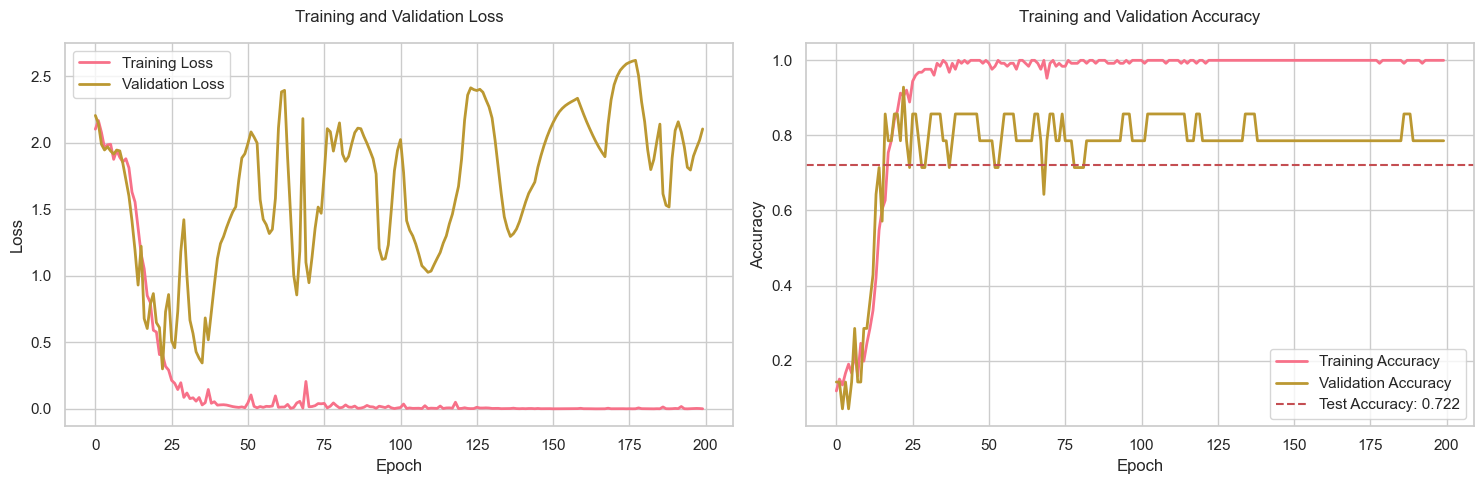

In [78]:
# Plot all metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
#plt.style.use('seaborn')
sns.set_palette("husl")

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
ax1.plot(metrics['train_losses'], label='Training Loss', linewidth=2)
ax1.plot(metrics['val_losses'], label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss', pad=15)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(metrics['train_accuracies'], label='Training Accuracy', linewidth=2)
ax2.plot(metrics['val_accuracies'], label='Validation Accuracy', linewidth=2)
ax2.set_title('Training and Validation Accuracy', pad=15)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Add a horizontal line for final test accuracy
ax2.axhline(y=metrics['test_acc'], color='r', linestyle='--', 
            label=f'Test Accuracy: {metrics["test_acc"]:.3f}')
ax2.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [79]:
# Print final metrics summary
print("\nFinal Metrics Summary:")
print(f"Best Validation Accuracy: {metrics['best_val_acc']*100:.2f}%")
print(f"Final Test Accuracy: {metrics['test_acc']*100:.2f}%")
print(f"Final Training Loss: {metrics['train_losses'][-1]:.4f}")
print(f"Final Validation Loss: {metrics['val_losses'][-1]:.4f}")


Final Metrics Summary:
Best Validation Accuracy: 92.86%
Final Test Accuracy: 72.20%
Final Training Loss: 0.0007
Final Validation Loss: 2.1033
